## Plotting regular waves per probe per file

In [355]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import hilbert

In [356]:
def get_waves(filename):
    data_list = [["time"],["Probe 1"],["Probe 2"],["Probe 3"], ["Probe 4"], ["Probe 5"]]
    with open('../Experimental Data-20201218/' + filename + ".txt") as txt:
        for row in txt.readlines():
            row_list = row.strip().split(" ")
            for i in range(len(data_list)-1):
                data_list[i].append(float(row_list[i]))
    return data_list


In [357]:
def plot_waves(data_list, filename, chunk, probe):
    # analytic_signal = hilbert(data_list[probe][1:])
    # amplitude_envelope = np.abs(analytic_signal)
    # wave_height = np.average(amplitude_envelope)
    beginning = int(len(data_list[0])/chunk)
    plt.figure(figsize=(15,5))
    plt.title("Random Waves Plot")
    plt.xlabel("time/sec")
    plt.ylabel("wave height/cm")
    plt.plot(data_list[0][1:beginning],data_list[probe][1:beginning],label=data_list[probe][0])
    # plt.plot(data_list[0][1:beginning],amplitude_envelope[:beginning-1],label="Probe 3 envelope")
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    # plt.axhline(y=wave_height, color='red', label="Significant Wave Height: {} cm".format(wave_height))
    plt.axvline(x=0, color='k')
    plt.legend()
    plt.savefig("../graphs/" + filename + str(chunk) + "thGraph.png")
    plt.show()

In [358]:
def get_celerities(data_list, probe1, probe2, filename, chunk, newdepth):
    beginning = int(len(data_list[0])/chunk)
    distance = 0
    g = 9.80665
    h= 0.40
    if (probe1 == 1):
        distance = 2.5
    elif (probe1 == 2):
        distance = 6.3
    elif (probe1 == 3):
        distance = 6.5
    elif (probe1 == 4):
        distance = 6.7
    elif (probe1 == 5):
        distance = 10.5
    if (probe2 == 1):
        distance -= 2.5
    elif (probe2 == 2):
        distance -= 6.3
    elif (probe2 == 3):
        distance -= 6.5
    elif (probe2 == 4):
        distance -= 6.7
    elif (probe2 == 5):
        distance -= 10.5
    times1 = get_data(data_list, probe1)[3]
    times2 = get_data(data_list, probe2)[3]
    periods = get_data(data_list, probe1)[1]
    amplitudes = get_data(data_list, probe1)[2]
    celerities = []
    Froude = []
    scaledCelerities = []
    scaledPeriods = []
    scaledWavelengths = []
    scaledAmplitudes = []
    scaledTimes = []
    scaledTime = 0
    for i in range(len(times1)):
        celerity = abs(distance/(times2[i] - times1[i]))
        wavelength = celerity * periods[i]
        scaledCel = celerity/(np.sqrt(h/newdepth))
        scaledLen = (wavelength * newdepth)/h
        scaledPer = scaledLen/scaledCel
        scaledAmp = (scaledPer * scaledCel * (amplitudes[i]*0.01))/(celerity * periods[i])
        scaledTime += scaledPer
        celerities.append(celerity)
        Froude.append(celerity/np.sqrt(g*h))
        scaledCelerities.append(scaledCel)
        scaledPeriods.append(scaledPer)
        scaledWavelengths.append(scaledLen)
        scaledAmplitudes.append(scaledAmp)
        scaledTimes.append(scaledTime)
        #print("{}/({} - {})".format(distance, times2[i], times1[i]))
    plt.figure(figsize=(15,5))
    plt.title("Random Waves Celerities Plot:\nC = (Distance between probes {} and {})/((Time at which probe {} measured the end of a period)/(Time at which probe {} measured the end of a period))".format(probe1, probe2, probe2, probe1))
    plt.xlabel("time/sec")
    # plt.ylabel("wave height/cm")
    # plt.plot(data_list[0][1:beginning],data_list[probe1][1:beginning],label=data_list[probe1][0])
    # plt.plot(data_list[0][1:beginning],data_list[probe2][1:beginning],label=data_list[probe2][0])
    plt.ylabel("Celerity m/s")
    plt.plot(times1[:beginning],celerities[:beginning],label="Celerities")
    plt.plot(times1[:beginning],Froude[:beginning],label="Froude number: Fr = C/sqrt(gh)")
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.legend()
    plt.savefig("../graphs/" + filename + "Celerities.png")
    plt.show()

    return (scaledTimes, scaledCelerities, scaledPeriods, scaledAmplitudes, scaledWavelengths)

In [359]:
def get_data(data, probe):
    periods = []
    heights = []
    times = []
    highest = 0
    lowest = 0
    last = 0
    for i in range(2,len(data[0])):
        if data[probe][i] > highest:
            highest = data[probe][i]
        elif data[probe][i] < lowest:
            lowest = data[probe][i]
        elif (data[probe][i - 1] > 0 and data[probe][i] <= 0):
            if last > 0:
                period = data[0][i] - last
                periods.append(period)
                times.append(last)
                height = highest - lowest
                heights.append(height)
            highest = 0
            lowest = 0
            last = data[0][i]

    root_mean_square_wave_height = np.sqrt(sum(map(lambda x: x ** 2, heights))/len(heights))
    max_height = np.amax(heights)
    mean_wave_height = sum(heights)/(len(heights))
    sig_wave_height = sum(heights[:int(len(heights)/3)])/(len(heights)/3)
    mean_zero_crossing_period = sum(periods)/(len(periods))
    number_of_periods = len(periods)
    return ((root_mean_square_wave_height,sig_wave_height,mean_zero_crossing_period, number_of_periods), periods, heights, times)

In [360]:
def plot_scaled(tup, depth):
    (time, celerities, periods, amplitudes, wavelengths) = tup
    plt.figure(figsize=(15,5))
    plt.title("Random Waves: Scaled amplitudes over scaled time (considering scaled periods) for depth h = {}".format(depth))
    plt.xlabel("time/sec")
    plt.ylabel("Amplitude/m")
    # plt.plot(time, celerities,label="Scaled Celerities")
    plt.plot(time, amplitudes,label="Scaled Amplitudes")
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.legend()
    plt.savefig("../graphs/RandScaled.png")
    plt.show()
    print("There are {} minutes of data for the real world site with depth h = {}m".format(time[len(time)-1]/60, depth))
    return (10800/time[len(time)-1], np.amax(amplitudes))


In [361]:
def rayleigh(portion, amplitudes, depth):
    H_RMS = np.sqrt(sum(map(lambda x: x ** 2, amplitudes))/len(amplitudes))
    sig_wave_height = np.sqrt(2) * H_RMS
    max = np.sqrt(np.log(len(amplitudes) * portion)) * H_RMS
    mean = sum(amplitudes)/(len(amplitudes))
    prob_density = []
    cum_prob_dist = []
    exceedance = []
    for height in amplitudes:
        exceedance.append(np.exp((-height ** 2)/(H_RMS ** 2)))
        prob_density.append(((2*height)/(H_RMS ** 2)) * exceedance[len(exceedance)-1])
        cum_prob_dist.append(1 - exceedance[len(exceedance)-1])
    plt.figure(figsize=(15,10))
    plt.title("Rayleigh Distribution for random sea state at real-world site with depth h = {}".format(depth))
    plt.ylabel("p(x) and P(x)")
    plt.plot(amplitudes, prob_density, ".", label="Probability Density")
    plt.plot(amplitudes, cum_prob_dist,".", label="Cumulative Probability Distribution")
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.axvline(x=mean, color="red", label="mean")
    plt.axvline(x=H_RMS, color="blue", label="H_RMS")
    plt.axvline(x=sig_wave_height, color="green", label="H_s")
    plt.axvline(x=max, color="purple", label="H_max")
    plt.legend()
    plt.savefig("../graphs/Rayleigh.png")
    plt.show()
    return (max, sig_wave_height)

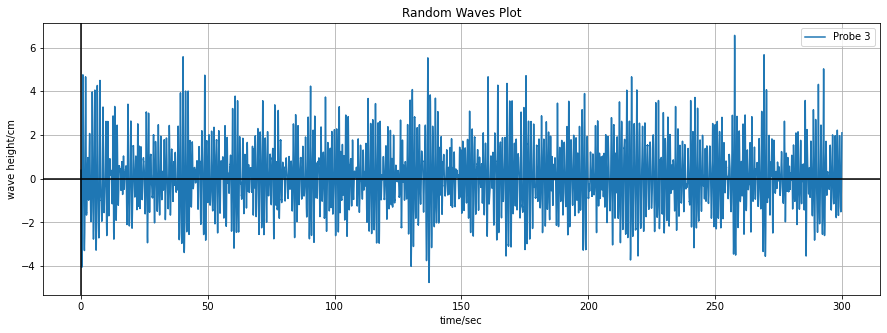

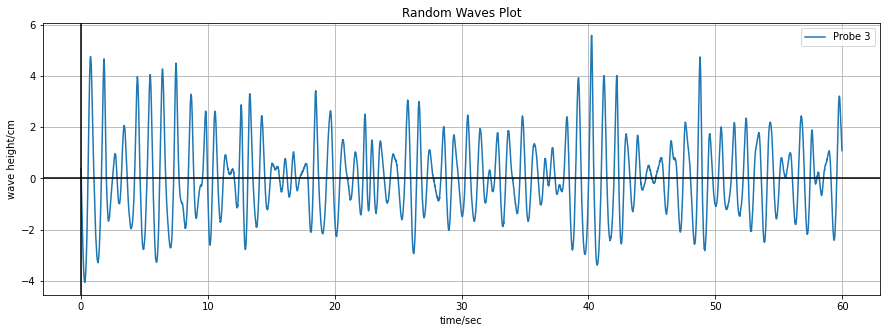

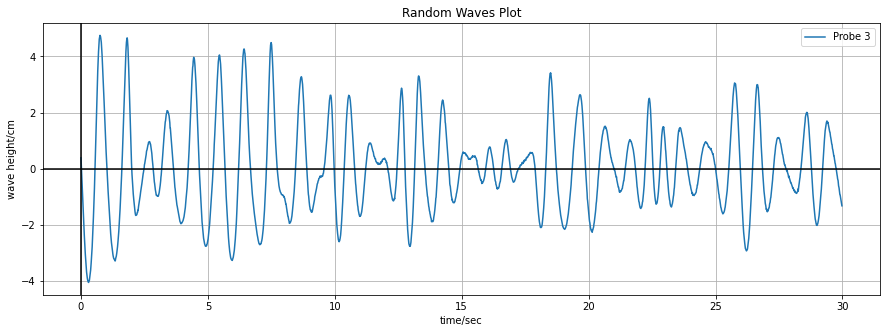

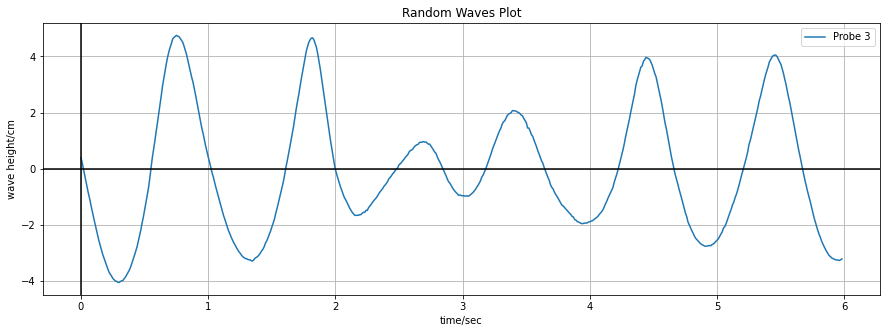

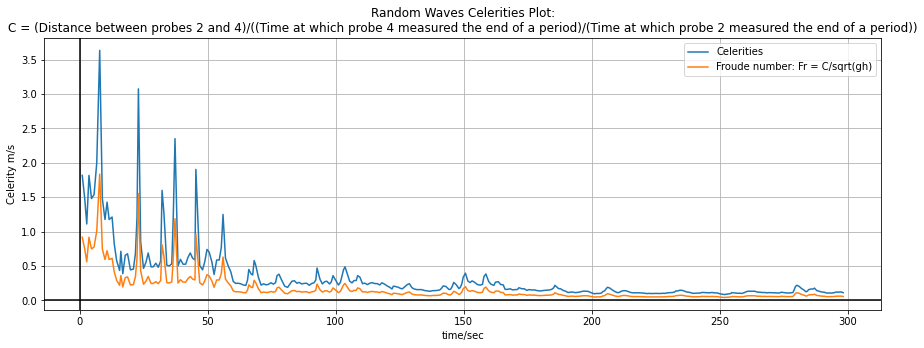

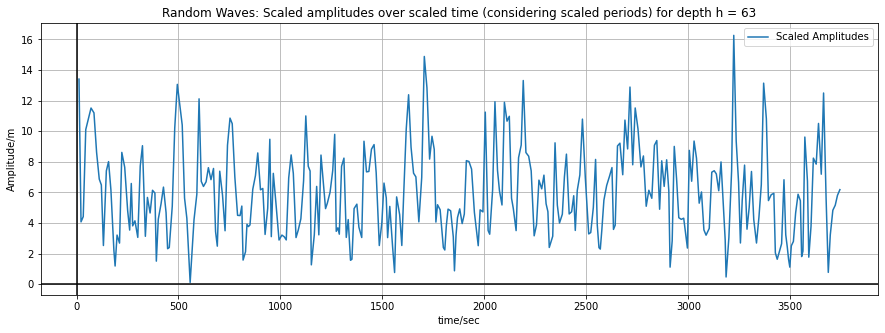

There are 62.387646528579694 minutes of data for the real world site with depth h = 63m


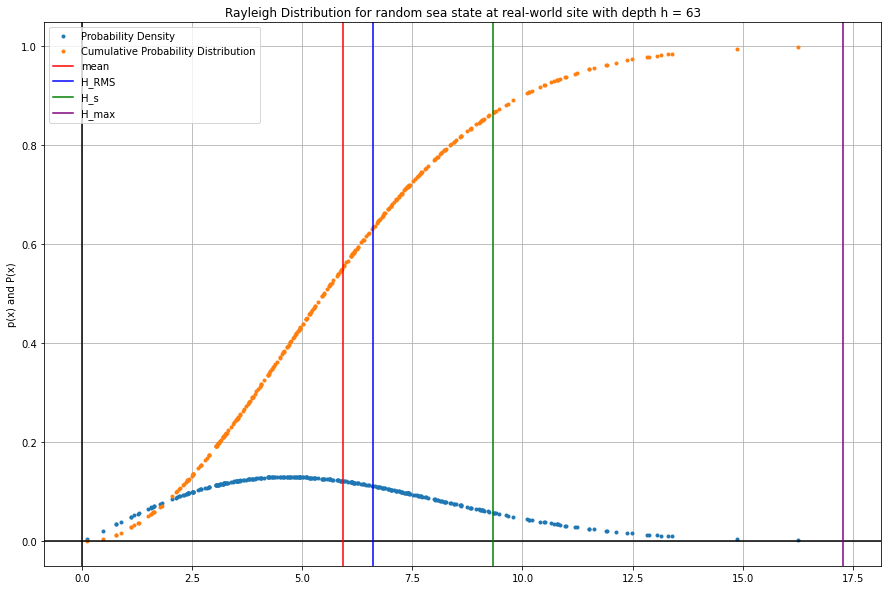

In [362]:
data = get_waves("Rand")
plot_waves(data,"Rand", 1, 3)
plot_waves(data,"Rand", 5, 3)
plot_waves(data,"Rand", 10, 3)
plot_waves(data,"Rand", 50, 3)
stats = get_data(data, 3)
celerities = get_celerities(data, 2, 4, "Rand", 1, 63)
(portion, maximum) = plot_scaled(celerities,63)
(max, sigheight) = rayleigh(portion,celerities[3], 63)